Scaler saved to C:\Users\demir\OneDrive\Desktop\MSc Thesis\Final Results\Saved_Models\minmax_scaler.pkl

=== Leaving out fuel: Cellulose ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 536
[LightGBM] [Info] Number of data points in the train set: 1522, number of used features: 11
[LightGBM] [Info] Start training from score 53.042872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

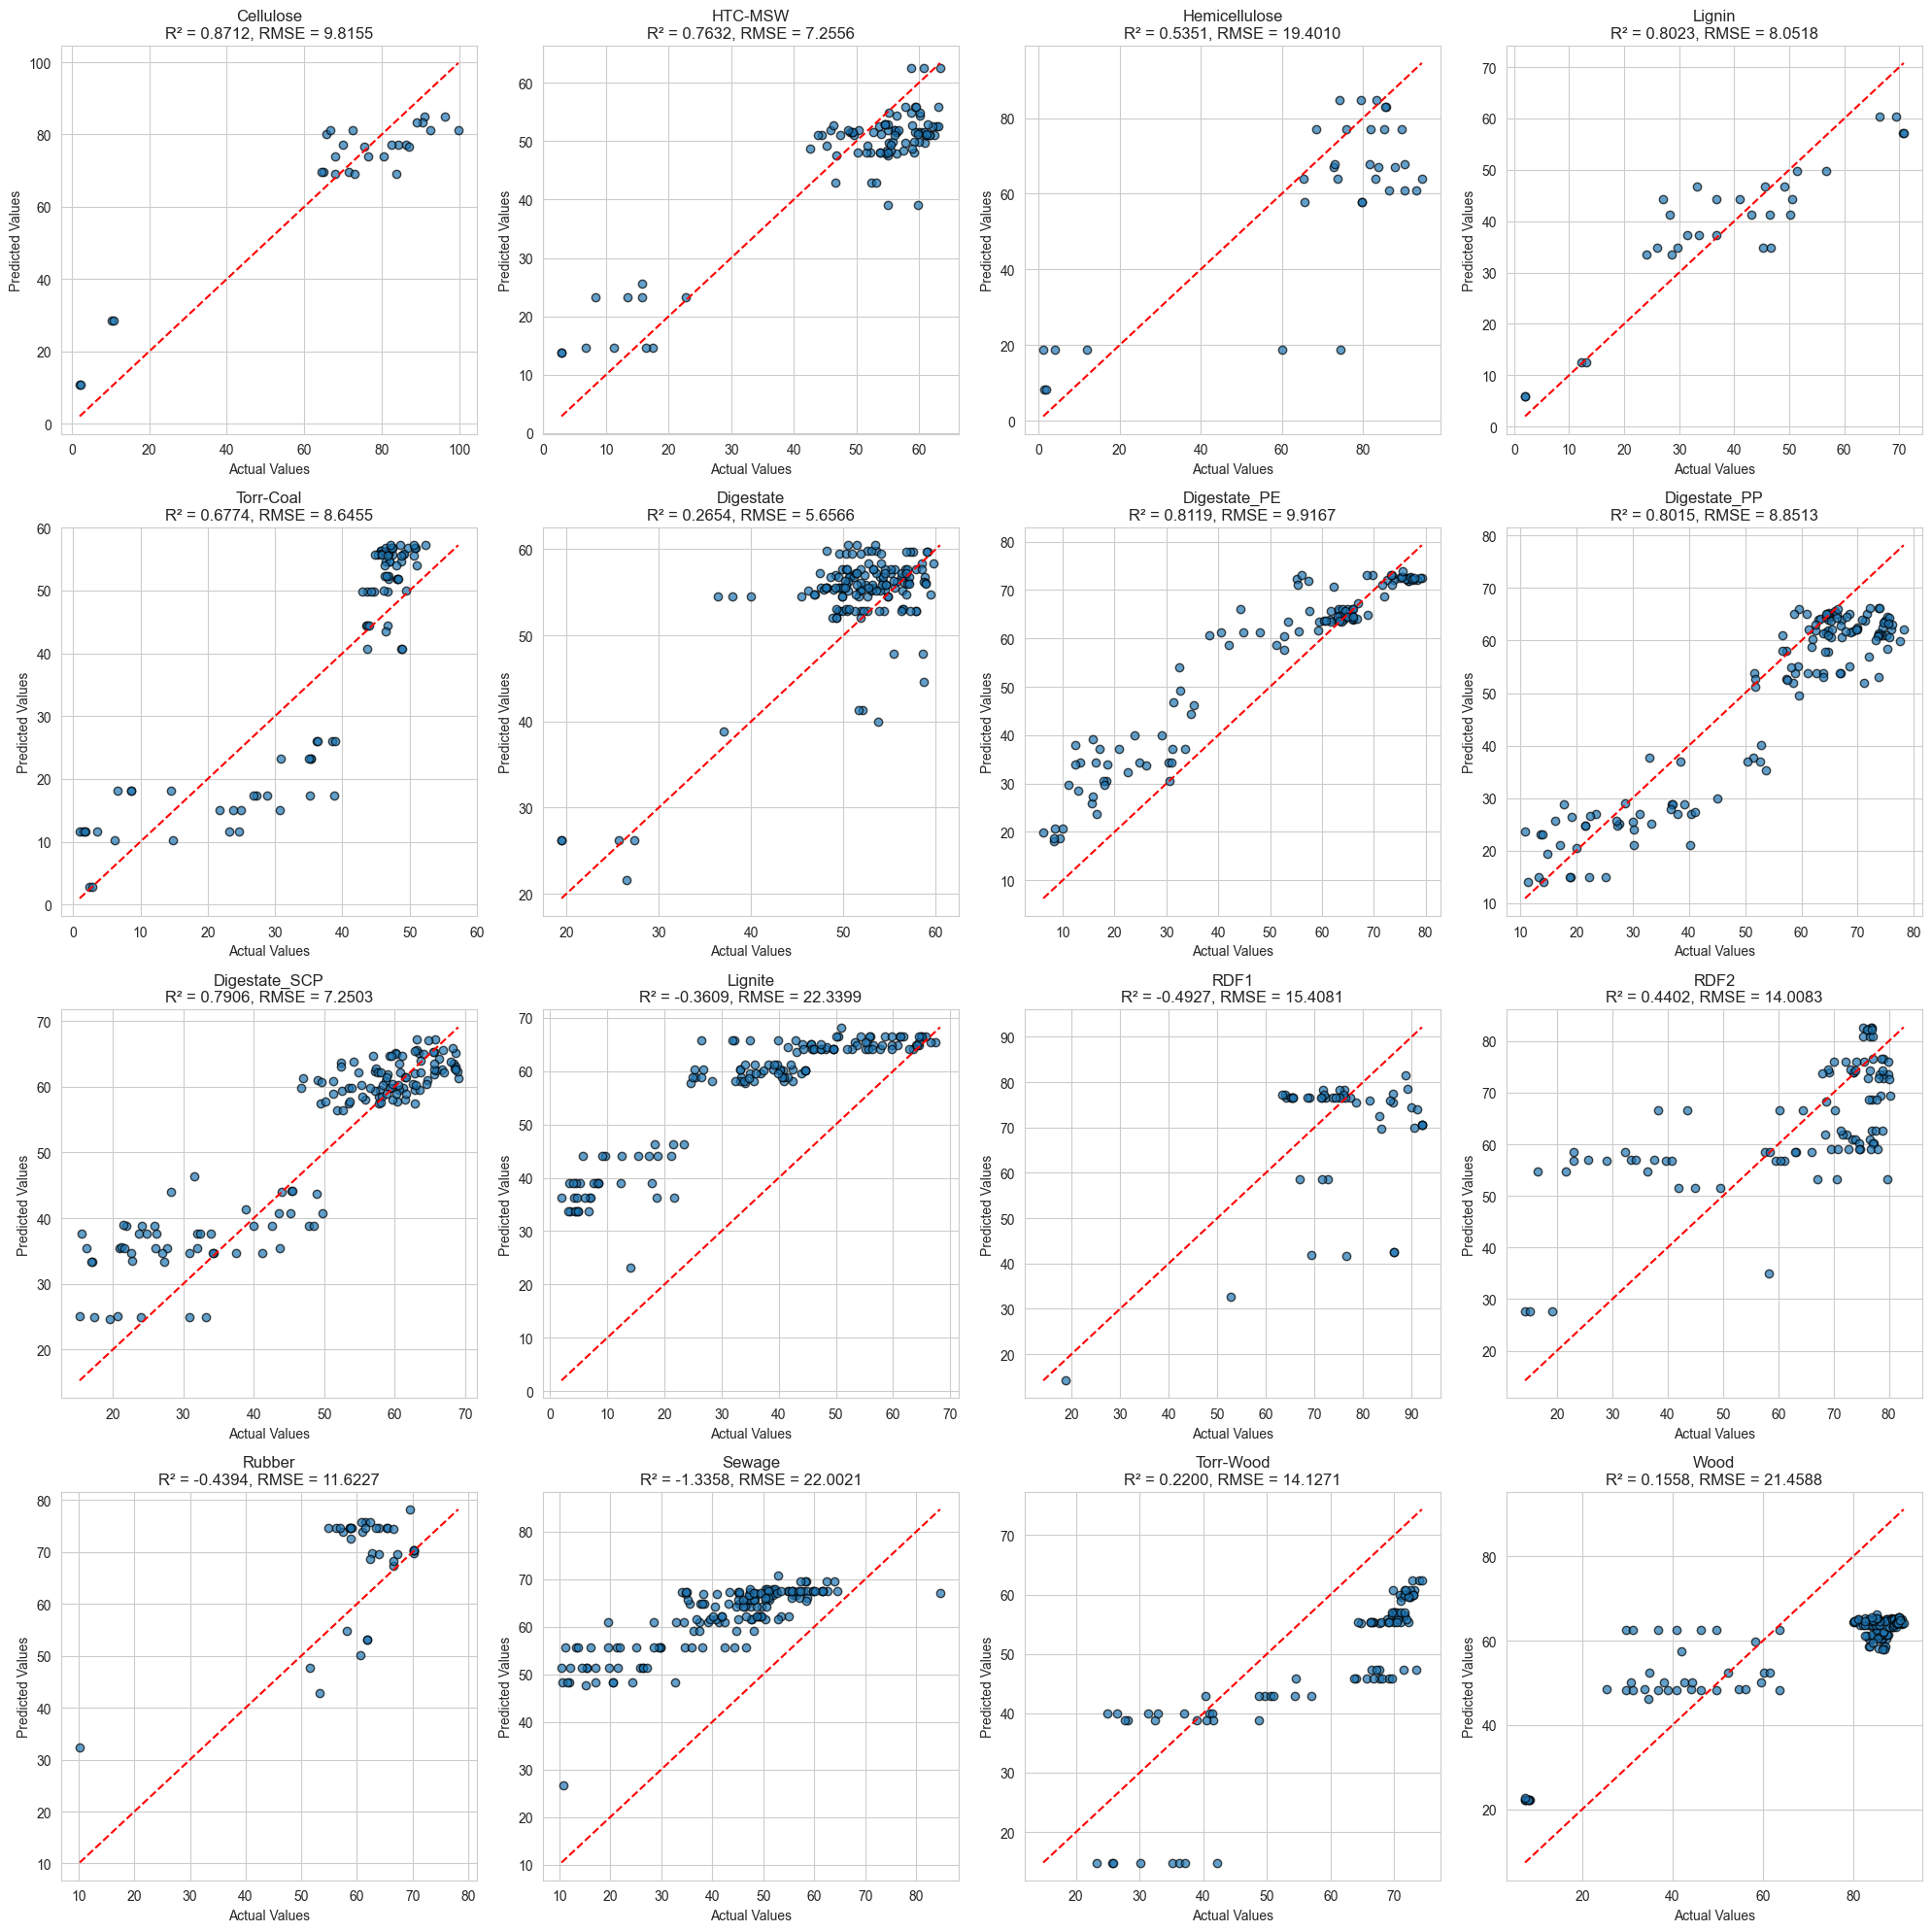


=== Summary of One-Fuel-Leave-Out Results ===
        Fuel Type        R2       RMSE        MAE  Train Time (s)
0       Cellulose  0.871162   9.815518   8.483188       15.903368
1         HTC-MSW  0.763199   7.255595   6.174877       10.453195
2   Hemicellulose  0.535120  19.400992  14.934929       11.081364
3          Lignin  0.802327   8.051850   6.649369       10.163066
4       Torr-Coal  0.677445   8.645532   7.754189       10.486506
5       Digestate  0.265366   5.656553   4.449428        7.838452
6    Digestate_PE  0.811870   9.916742   7.328145       11.180044
7    Digestate_PP  0.801464   8.851341   7.204048        6.254638
8   Digestate_SCP  0.790597   7.250318   5.529634        7.622686
9         Lignite -0.360871  22.339943  19.868987        6.625887
10           RDF1 -0.492746  15.408148  11.691922        9.040981
11           RDF2  0.440212  14.008261  10.767688       10.836306
12         Rubber -0.439356  11.622720   9.905645        9.155438
13         Sewage -1.335771  

In [14]:
from sklearn.ensemble import VotingRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
import joblib
import time
import os
from scipy.stats import randint, uniform

# Create directory for saving models if it doesn't exist
save_dir = (r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Final Results\Saved_Models")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Load data
data_path = r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Final Results\Final Data Used\final_data_filtered_ohe.csv"
df = pd.read_csv(data_path, delimiter=',')

# === Feature Engineering ===
epsilon = 1e-6
df['vm_fc_ratio'] = df['vm'] / (df['fc'] + epsilon)
df['ac_fc_ratio'] = df['ac'] / (df['fc'] + epsilon)
df['n_cl_ratio'] = df['n'] / (df['cl'] + epsilon)

# === Define feature columns ===
feature_cols = [
    'h', 'wc', 'c', 'lhv', 'o', 'n', 's', 'cl',
    'hc', 'oc', 'temperature', 'residence_time', 'pressure', 'heat_rate',
    'vm_fc_ratio', 'ac_fc_ratio', 'n_cl_ratio'
]

# === Expanded bounds for MinMaxScaler ===
min_vm_fc_ratio = df['vm_fc_ratio'].min()
max_vm_fc_ratio = df['vm_fc_ratio'].max()
min_ac_fc_ratio = df['ac_fc_ratio'].min()
max_ac_fc_ratio = df['ac_fc_ratio'].max()
min_n_cl_ratio = df['n_cl_ratio'].min()
max_n_cl_ratio = df['n_cl_ratio'].max()

min_values = {
    'wc': 2.6, 'vm': 44.2, 'fc': 3.064326, 'ac': 0.0, 'c': 32.4, 'h': 3.265 , 'lhv': 13.528,
    'o': 7.0, 'n': 0.269662, 's': 0.04642, 'cl': 0.0, 'hc': 0.7, 'oc': 0.0,
    'temperature': 200, 'residence_time': 0.5, 'pressure': 0.5, 'heat_rate': 10,
    'vm_fc_ratio': min_vm_fc_ratio, 'ac_fc_ratio': min_ac_fc_ratio, 'n_cl_ratio':min_n_cl_ratio
}
max_values = {
    'wc': 10.8, 'vm': 91.735674, 'fc': 44.5, 'ac': 37.52, 'c': 82.3, 'h': 10.13205, 'lhv': 35.8,
    'o': 54.936839, 'n': 3.9, 's': 2.5, 'cl': 1.5, 'hc': 1.857, 'oc': 1.04402,
    'temperature': 1200, 'residence_time': 20, 'pressure': 20, 'heat_rate': 1000,
    'vm_fc_ratio': max_vm_fc_ratio, 'ac_fc_ratio': max_ac_fc_ratio, 'n_cl_ratio': max_n_cl_ratio
}
margin_ratio = 0.4
expanded_bounds = {}
for feat in feature_cols:
    min_val = min_values[feat]
    max_val = max_values[feat]
    range_val = max_val - min_val
    new_min = max(0, min_val - range_val * margin_ratio)
    new_max = max_val + range_val * margin_ratio
    expanded_bounds[feat] = (round(new_min, 3), round(new_max, 3))

X_bounds = pd.DataFrame({col: [expanded_bounds[col][0], expanded_bounds[col][1]] for col in feature_cols})
scaler = MinMaxScaler()
scaler.fit(X_bounds)

# Save scaler for reproducibility
joblib.dump(scaler, os.path.join(save_dir, 'minmax_scaler.pkl'))
print(f"Scaler saved to {os.path.join(save_dir, 'minmax_scaler.pkl')}")

# === Prepare Fuel Types ===
fuel_types = df['fuel_type'].unique()

# === Function to Evaluate Model ===
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)

    metrics = {
        "Model": model_name,
        "R2": r2_score(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "Training Time (s)": train_time
    }

    return metrics, y_pred, model

# === Models ===
def get_base_models():
    best_mlp = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', max_iter=2000, random_state=42)
    best_gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=4, random_state=42)
    best_xgb = xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=4, random_state=42)
    best_lgb = lgb.LGBMRegressor(n_estimators=300, learning_rate=0.1, max_depth=4, random_state=42)
    best_lasso = Lasso(alpha=1.0)
    best_knn = KNeighborsRegressor(n_neighbors=3, metric='minkowski')

    return best_mlp, best_gbr, best_xgb, best_lgb, best_lasso, best_knn

# === Leave-One-Fuel-Out Cross-Validation ===
results = []
all_parity_data = []  # Store all parity data for tile plots

# Calculate optimal grid size for subplots based on number of fuel types
n_fuels = len(fuel_types)
grid_size = int(np.ceil(np.sqrt(n_fuels)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(5*grid_size, 5*grid_size))
axes = axes.flatten() if n_fuels > 1 else [axes]

# Main training and evaluation loop
for i, fuel in enumerate(fuel_types):
    print(f"\n=== Leaving out fuel: {fuel} ===")

    # Split
    train_data = df[df['fuel_type'] != fuel]
    test_data = df[df['fuel_type'] == fuel]

    X_train = train_data[feature_cols]
    y_train = train_data['devol_yield']
    X_test = test_data[feature_cols]
    y_test = test_data['devol_yield']

    # Scale and drop features
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=feature_cols, index=X_train.index).drop(['wc', 'c', 'o', 'h', 'n', 'cl'], axis=1)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=feature_cols, index=X_test.index).drop(['wc', 'c', 'o', 'h', 'cl', 'n'], axis=1)

    # Get new models for each fold
    best_mlp, best_gbr, best_xgb, best_lgb, best_lasso, best_knn = get_base_models()

    # Voting Regressor
    voting_regressor = VotingRegressor(
        estimators=[
            ('mlp', best_mlp),
            ('gbr', best_gbr),
            ('xgb', best_xgb),
            ('lgb', best_lgb),
            ('lasso', best_lasso),
            ('knn', best_knn)
        ],
        weights=[1,2,2,1,1,0.5]
    )

    # Evaluate
    metrics, y_pred, trained_model = evaluate_model(voting_regressor, f"VotingRegressor - {fuel}", X_train_scaled, y_train, X_test_scaled, y_test)
    results.append((fuel, metrics, y_test, y_pred))

    # Store parity data for this fuel
    all_parity_data.append({
        'fuel': fuel,
        'actual': y_test,
        'predicted': y_pred,
        'r2': metrics['R2'],
        'rmse': metrics['RMSE']
    })

    # Print metrics
    print(f"R2 Score: {metrics['R2']:.4f}")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"MAE: {metrics['MAE']:.4f}")

    # Save model for this fold
    model_filename = os.path.join(save_dir, f'voting_regressor_{fuel.replace(" ", "_")}.pkl')
    joblib.dump(trained_model, model_filename)
    print(f"Model for fuel '{fuel}' saved to {model_filename}")

    # Plot individual parity plot in the subplot grid
    ax = axes[i]
    ax.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')

    # Add diagonal line (perfect prediction line)
    min_val = min(min(y_test), min(y_pred))
    max_val = max(max(y_test), max(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')

    # Add labels and metrics
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'{fuel}\nR² = {metrics["R2"]:.4f}, RMSE = {metrics["RMSE"]:.4f}')
    ax.grid(True)

# Hide any extra subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'all_fuels_parity_plots.png'), dpi=300, bbox_inches='tight')
plt.show()

# === Final Summary Table ===
summary = pd.DataFrame([{
    'Fuel Type': fuel,
    'R2': metrics['R2'],
    'RMSE': metrics['RMSE'],
    'MAE': metrics['MAE'],
    'Train Time (s)': metrics['Training Time (s)']
} for fuel, metrics, _, _ in results])

print("\n=== Summary of One-Fuel-Leave-Out Results ===")
print(summary)

# Save summary results to CSV
summary.to_csv(os.path.join(save_dir, 'lofo_results_summary.csv'), index=False)
print(f"Summary results saved to {os.path.join(save_dir, 'lofo_results_summary.csv')}")

# === Train and save a final model using all data ===
print("\n=== Training final model on all data ===")
X_all = df[feature_cols]
y_all = df['devol_yield']
X_all_scaled = pd.DataFrame(scaler.transform(X_all), columns=feature_cols).drop(['wc', 'c', 'o', 'h', 'n', 'cl'], axis=1)

# Get a fresh set of models
best_mlp, best_gbr, best_xgb, best_lgb, best_lasso, best_knn = get_base_models()

# Create final voting regressor
final_voting_regressor = VotingRegressor(
    estimators=[
        ('mlp', best_mlp),
        ('gbr', best_gbr),
        ('xgb', best_xgb),
        ('lgb', best_lgb),
        ('lasso', best_lasso),
        ('knn', best_knn)
    ],
    weights=[1,2,2,1,0.5,0.5]
)

# Train and save the final model
start_time = time.time()
final_voting_regressor.fit(X_all_scaled, y_all)
train_time = time.time() - start_time

# Save the final model
final_model_filename = os.path.join(save_dir, 'final_voting_regressor_all_data.pkl')
joblib.dump(final_voting_regressor, final_model_filename)
print(f"Final model trained on all data saved to {final_model_filename}")
print(f"Final model training time: {train_time:.2f} seconds")

# Save feature information (which features are used in the final model)
with open(os.path.join(save_dir, 'model_features_info.txt'), 'w') as f:
    f.write("Features used in the model after scaling and dropping:\n")
    f.write(','.join(X_all_scaled.columns))
    f.write("\n\nOriginal features before dropping:\n")
    f.write(','.join(feature_cols))

print("Script completed successfully!")

Text(0, 0.5, 'Predicted devol_yield')

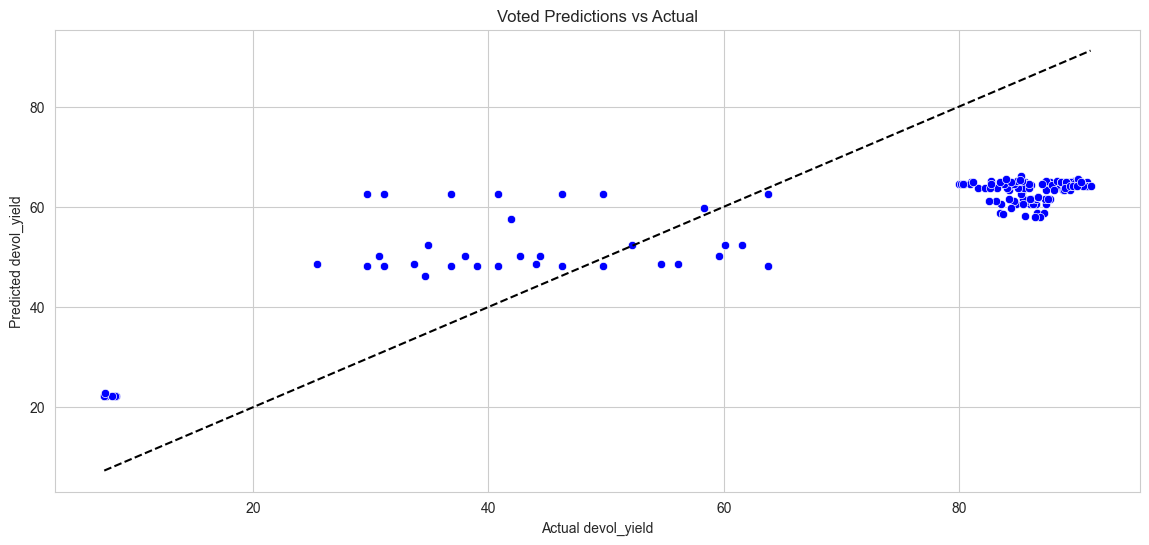

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.scatterplot(x=y_test, y=y_pred, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title("Voted Predictions vs Actual")
plt.xlabel("Actual devol_yield")
plt.ylabel("Predicted devol_yield")

Scaler saved to saved_models\minmax_scaler.pkl

=== Leaving out fuel: Cellulose ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 536
[LightGBM] [Info] Number of data points in the train set: 1522, number of used features: 11
[LightGBM] [Info] Start training from score 53.042872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

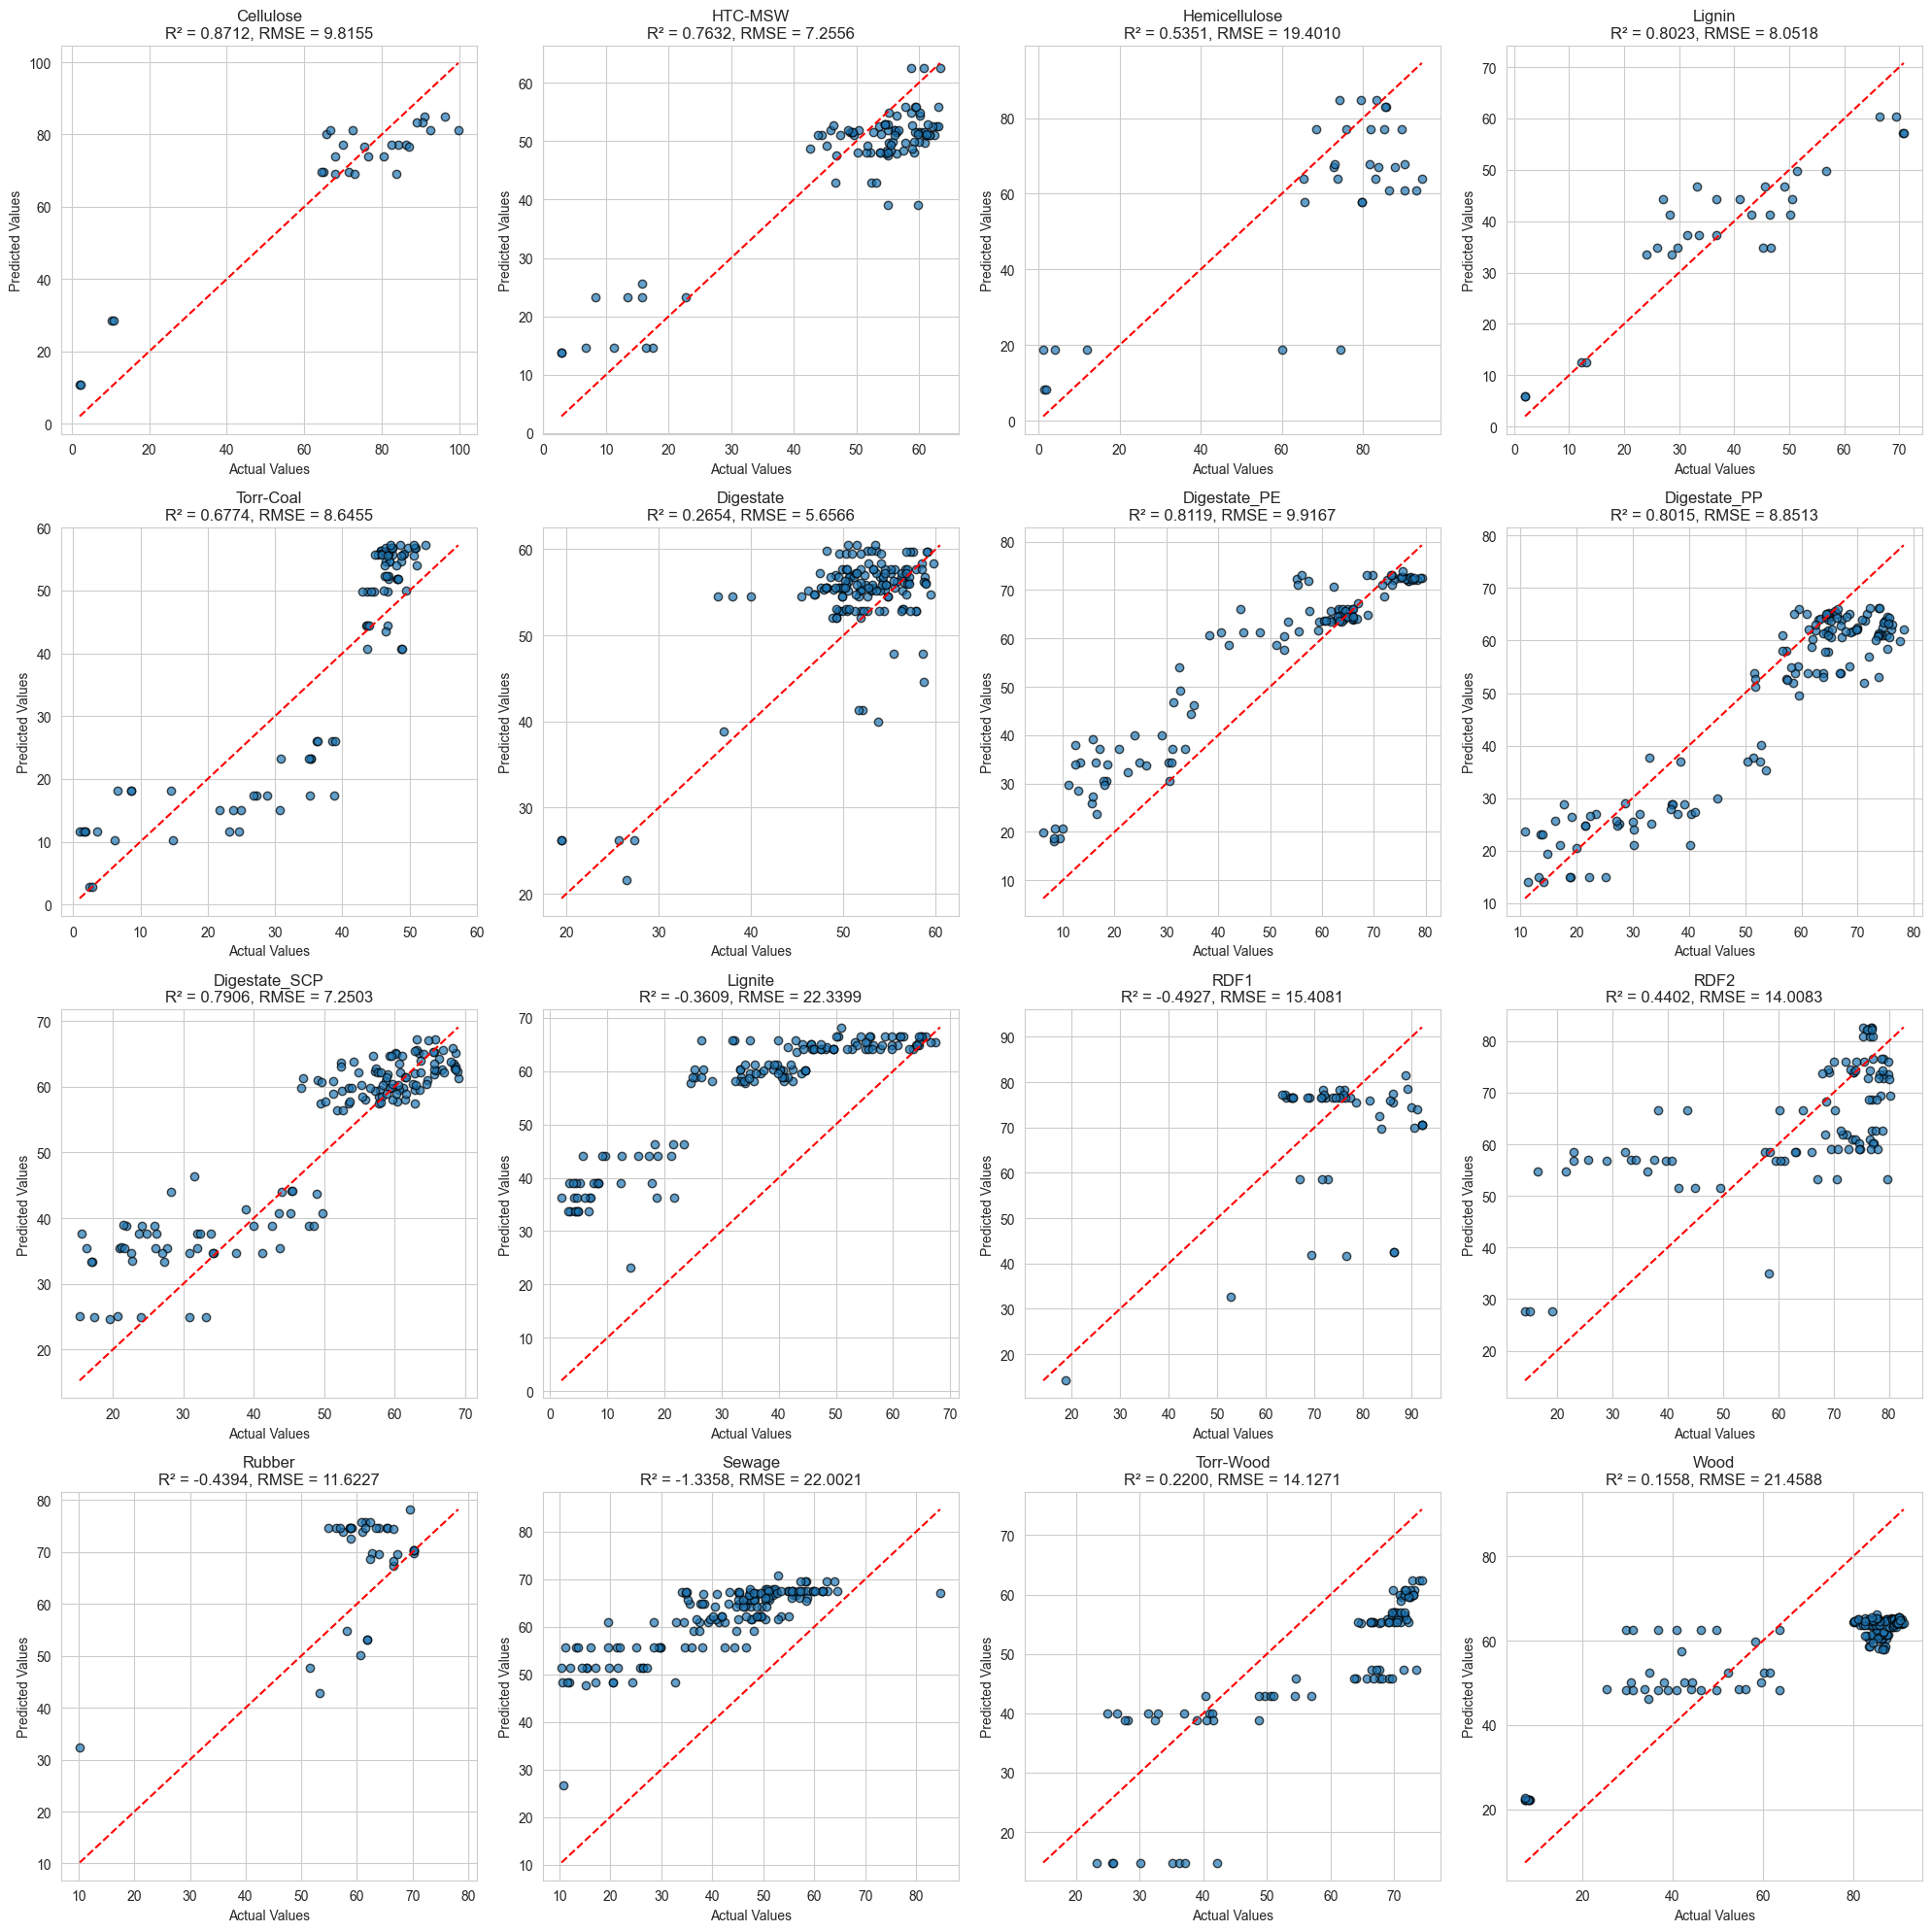


=== Summary of One-Fuel-Leave-Out Results ===
        Fuel Type        R2       RMSE        MAE  Train Time (s)
0       Cellulose  0.871162   9.815518   8.483188       13.670276
1         HTC-MSW  0.763199   7.255595   6.174877        8.315278
2   Hemicellulose  0.535120  19.400992  14.934929        9.716717
3          Lignin  0.802327   8.051850   6.649369        9.268023
4       Torr-Coal  0.677445   8.645532   7.754189       10.240903
5       Digestate  0.265366   5.656553   4.449428        7.497805
6    Digestate_PE  0.811870   9.916742   7.328145       10.789885
7    Digestate_PP  0.801464   8.851341   7.204048        5.727991
8   Digestate_SCP  0.790597   7.250318   5.529634        7.857687
9         Lignite -0.360871  22.339943  19.868987        5.740480
10           RDF1 -0.492746  15.408148  11.691922        8.703740
11           RDF2  0.440212  14.008261  10.767688       10.826716
12         Rubber -0.439356  11.622720   9.905645        8.646393
13         Sewage -1.335771  